In [ ]:
# Install required packages
!pip install transformers datasets accelerate evaluate
!pip install torch torchvision
!pip install matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoFeatureExtractor, AutoModelForSemanticSegmentation
from PIL import Image
import requests
from io import BytesIO
import cv2

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load a pre-trained semantic segmentation model (DeepLabV3+ with ResNet-101 backbone)
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"

# Load the feature extractor and model
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = AutoModelForSemanticSegmentation.from_pretrained(model_name)

# Move model to the appropriate device
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

In [ ]:
def load_image_from_url(url):
    """Load an image from a URL."""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

def load_image_from_path(path):
    """Load an image from a local path."""
    return Image.open(path)

In [ ]:
def segment_image(image, model, feature_extractor):
    """Perform semantic segmentation on an image."""
    # Prepare image for the model
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the semantic segmentation map
    logits = logits.cpu()
    upsampled_logits = torch.nn.functional.interpolate(
        logits,
        size=image.size[::-1],  # (height, width)
        mode="bilinear",
        align_corners=False,
    )

    # Get the predicted class for each pixel
    seg_map = upsampled_logits.argmax(dim=1)[0]
    return seg_map.numpy()

In [ ]:
def visualize_segmentation(image, seg_map, id2label):
    """Visualize the segmentation results."""
    # Convert the segmentation map to RGB
    color_seg = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)

    # Create a colormap for visualization
    np.random.seed(42)
    colors = [np.random.randint(0, 255, 3) for _ in range(len(id2label))]

    # Assign a color to each class
    for label_id, label in id2label.items():
        color_seg[seg_map == int(label_id)] = colors[int(label_id)]

    # Convert PIL Image to numpy array for visualization
    img_array = np.array(image)

    # Create a figure with subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))

    # Original image
    axs[0].imshow(img_array)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Segmentation map
    axs[1].imshow(color_seg)
    axs[1].set_title('Segmentation Map')
    axs[1].axis('off')

    # Overlay segmentation on original image
    alpha = 0.5
    overlay = cv2.addWeighted(img_array, 1-alpha, color_seg, alpha, 0)
    axs[2].imshow(overlay)
    axs[2].set_title('Overlay')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Display some of the detected classes
    detected_classes = set(np.unique(seg_map))
    class_names = [id2label[str(i)] for i in detected_classes if str(i) in id2label]
    print(f"Detected classes: {', '.join(class_names[:10])}")
    if len(class_names) > 10:
        print(f"...and {len(class_names) - 10} more classes")

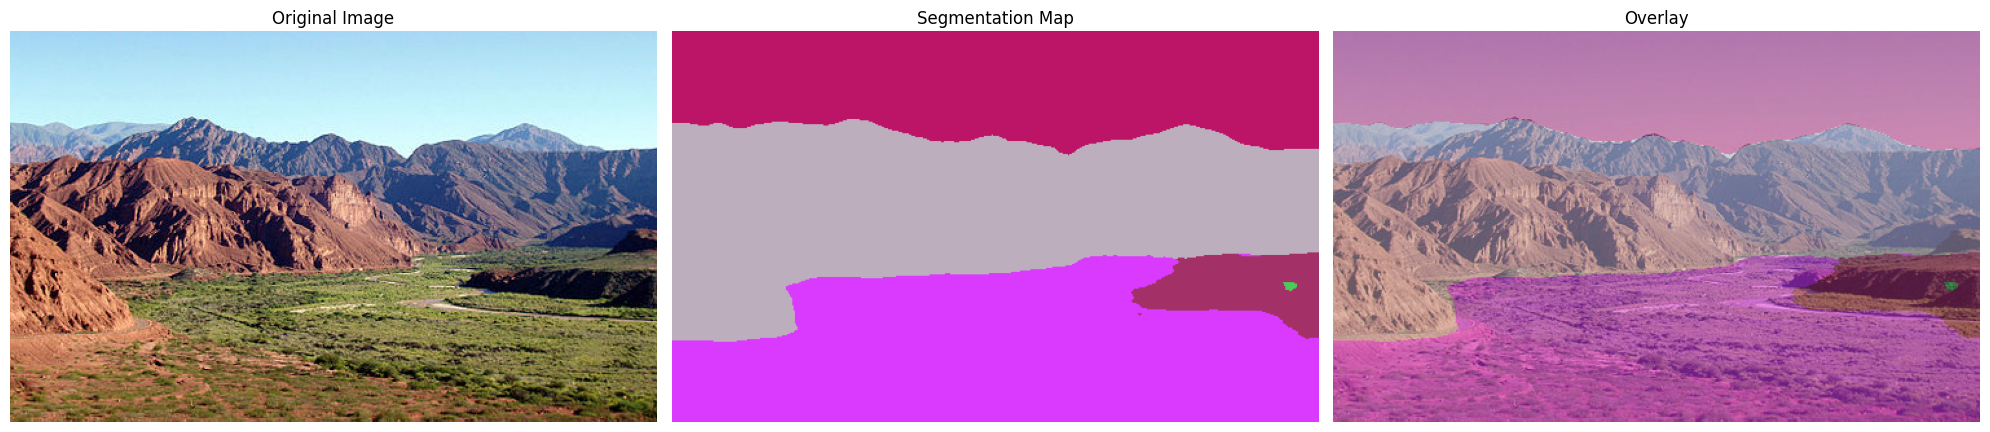

Detected classes: 


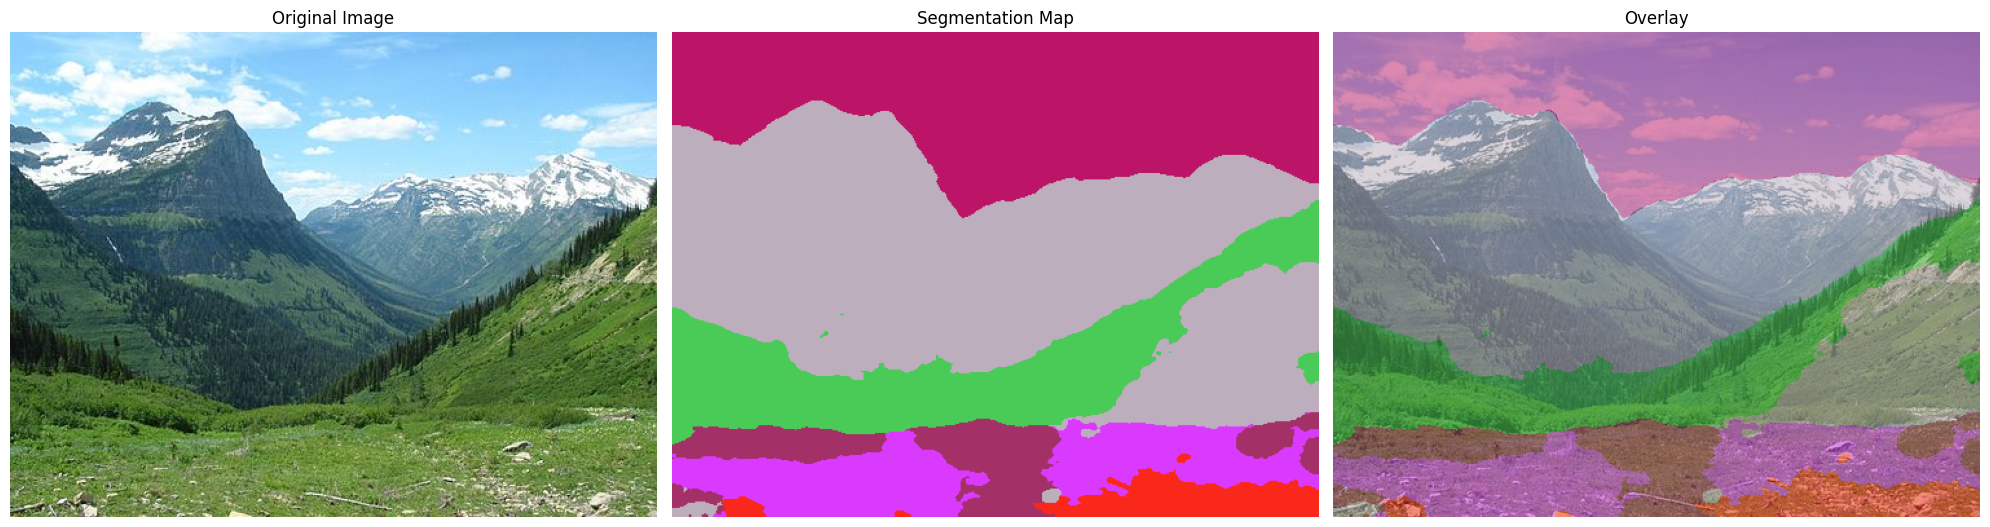

Detected classes: 


In [ ]:
# Get the id2label mapping from the model config
id2label = model.config.id2label

# Example 1: Indoor scene
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/50/Salta-VallesCalchaquies-P3140151.JPG/500px-Salta-VallesCalchaquies-P3140151.JPG"
image = load_image_from_url(image_url)
seg_map = segment_image(image, model, feature_extractor)
visualize_segmentation(image, seg_map, id2label)

# Example 2: Outdoor scene
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Glacier_park1.jpg/500px-Glacier_park1.jpg"
image = load_image_from_url(image_url)
seg_map = segment_image(image, model, feature_extractor)
visualize_segmentation(image, seg_map, id2label)